In [1081]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import numpy as np
import scipy
from scipy.special import gammaln
from scipy.stats import norm
from scipy.stats import t as student_t


In [1082]:
# Load each
datasets = {}
for hour in range(24):
    datasets[hour] = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

datasets_train = {hour: datasets[hour][(datasets[hour]['DATE'] >= '2014-01-01') & (datasets[hour]['DATE'] < '2023-01-01')].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}
datasets_test = {hour: datasets[hour][datasets[hour]['DATE'] >= '2023-01-01'].drop(['DATE'], axis=1).to_numpy() for hour in range(24)}

y_train = {hour: datasets_train[hour][:, 0].reshape(-1, 1) for hour in range(24)}
y_test = {hour: datasets_test[hour][:, 0].reshape(-1, 1) for hour in range(24)}

weather_train = {hour: datasets_train[hour][:, 1:-1] for hour in range(24)}
weather_test = {hour: datasets_test[hour][:, 1:-1] for hour in range(24)}


In [1083]:
Y = y_train[20]
X = weather_train[20]
X = X[:,27:30]

## DAR MLE

In [1084]:
def MLE_DAR(Y):
    
    # Time array t
    max_lag = 1
    T = len(Y)
    Y = np.vstack([np.full((max_lag, 1), np.nan), Y])
    t = np.arange(start = -1, stop = -(T + 1), step = -1)

    def loglikelihood_function(params):

        rho, omega, alpha = params
        
        # Define function objects at time t
        y = lambda t: Y[t]
        sigma = lambda t: np.sqrt(omega + alpha * y(t-1)**2)

        # Define conditional expectation and conditional variance at time t
        cond_mean = lambda t: rho * y(t-1)
        cond_var = lambda t: sigma(t)**2
        
        # compute sum of likelihood contributions
        l_t = -1/2 * (np.log(cond_var(t)) + (y(t) - cond_mean(t))**2 / cond_var(t))
        L_t = np.nansum(l_t)
        return -L_t
    
    # initialise parameters
    rho_init = 0.0
    omega_init = 0.05
    alpha_init = 0.5
    init_params = np.array([rho_init, omega_init, alpha_init])

    # set parameter bounds
    rho_bound = (0,None)
    omega_bound = (0,None)
    alpha_bound = (0,None)
    bounds_params = (rho_bound, omega_bound, alpha_bound)

    MLE_estimates = scipy.optimize.minimize(loglikelihood_function, init_params, method='SLSQP', bounds = bounds_params)

    return MLE_estimates.x

In [376]:
DAR_params = MLE_DAR(Y)
DAR_params

array([1.11537111e+00, 5.44034483e+03, 3.41321437e+00])

## DAR Forecast

In [381]:
def DAR_forecast(parameters, Y):
    
    rho, omega, alpha = parameters
    
    max_lag = 0
    T = len(Y)
    Y = np.vstack([np.full((max_lag, 1), np.nan), Y])

    # Time array t
    t = np.arange(start = -1, stop = -(T + 1), step = -1)

    # Define function objects at time t    
    y = lambda t: Y[t]
    sigma = lambda t: np.sqrt(omega + alpha * y(t-1)**2)
    
    # 1-step-ahead forecast array
    expected_mean = rho * y(t)
    
    return np.flip(np.append(expected_mean, np.nan)).reshape(-1,1)

In [384]:
DAR_params[0] 

1.1153711071407957

In [382]:
fcast = DAR_forecast(DAR_params,Y)
fcast

array([[         nan],
       [256.07804803],
       [238.94594782],
       ...,
       [207.43671404],
       [ 12.02370053],
       [123.50504604]])

In [999]:
def DAR_sim(parameters, T, set_seed):
    np.random.seed(set_seed)
    rho, omega, alpha = parameters

    max_lag = 1
    
    # Initialize arrays
    Y = np.zeros(T)
    Z = np.random.normal(loc=0, scale=1, size=T)

    # Initialize the process
    Y[0] = 1 

    # Define function objects at time t
    y = lambda t: Y[t]
    z = lambda t: Z[t]
    sigma = lambda t: np.sqrt(omega + alpha * Y[t-1]**2)
    epsilon = lambda t: sigma(t) * z(t)

    # The model
    DAR = lambda t: rho * y(t-1) + epsilon(t)

    # Update Y
    for t in range(max_lag, T):
        Y[t] = DAR(t)
    return Y

## DARMA-X CLASS

In [1094]:
class DARMAX:
    def __init__(self, p):
        """
        Initialize the DARMA-X class
        """
        self.p = p
        self.d = 0
        self.num_params = None
        self.params = None
        self.loglike_val = None
        self.T = None
    
    def t(self, Y):
        T = len(Y)
        self.T = T
        t = np.arange(start=-1, stop=-(T+1), step=-1)
        
        return t
    
    def y(self, Y):
        
        max_lag = self.p + 1

        Y = np.vstack((np.full((max_lag, Y.shape[1]), np.nan), Y))
        y = lambda t: Y[t,:]
        
        return y
    
    def x(self, X = None):

        max_lag = self.p + 1

        if X is None:
            x = lambda t: np.zeros((self.d,))
        else:
            X = np.vstack((np.full((max_lag, X.shape[1]), np.nan), X))
            x = lambda t: X[t, :]
        
        return x

    def parse_params(self, params):
        p, d = self.p, self.d

        rho = params[:p]
        omega, phi = params[p], params[p + 1]
        alpha = params[p + 2:p + 2 + p]
        gamma = params[p + 2 + p:p + 2 + p + p * d].reshape(p, d) if p * d > 0 else np.zeros((p, d))
        nu = params[-1] if len(params) > p + 2 + p + p * d else None

        return {
            "rho": rho,
            "omega": omega,
            "phi": phi,
            "alpha": alpha,
            "gamma": gamma,
            **({"nu": nu} if nu is not None else {})
        }

    def cond_var(self, Y, X = None, params = None):
        
        omega = params["omega"]
        alpha = params["alpha"]
        gamma = params["gamma"]

        y = self.y(Y)
        x = self.x(X)

        sigma = lambda t: np.sqrt(omega
                                  + sum(alpha[i-1] * y(t-i)**2 for i in range(1, self.p+1))
                                  + sum((gamma[i-1] @ x(t-i).T**2).reshape(-1, 1) for i in range(1, self.p+1))
                                  )
        
        cond_var = lambda t: sigma(t)**2

        return cond_var
    
    def cond_mean(self, Y, X = None, params = None):
  
        rho = params["rho"]
        omega = params["omega"]
        alpha = params["alpha"]
        gamma = params["gamma"]
        phi = params["phi"]

        y = self.y(Y)
        x = self.x(X)
        
        sigma = lambda t: np.sqrt(omega
                                  + sum(alpha[i-1] * y(t-i)**2 for i in range(1, self.p+1))
                                  + sum((gamma[i-1] @ x(t-i).T**2).reshape(-1, 1) for i in range(1, self.p+1))
                                  )
        
        beta = lambda t: phi * (y(t) - sum(rho[i-1] * y(t-i) for i in range(1, self.p + 1))) / sigma(t)

        cond_mean = lambda t: sum(rho[i-1] * y(t-i) for i in range(1, self.p + 1)) + sigma(t) * beta(t-1)

        return cond_mean
    
    def fit_normal(self, Y, X = None):

        t = self.t(Y)
        self.d = 0 if X is None else X.shape[1]
        self.num_params = 2 + (2 + self.d) * self.p
        
        def MLE(params):
            
            params = self.parse_params(params)
            
            y = self.y(Y)
            cond_var = self.cond_var(Y, X, params)
            cond_mean = self.cond_mean(Y, X, params)

            l_t = -1/2 * (np.log(cond_var(t)) + (y(t) - cond_mean(t))**2 / cond_var(t))
            L_t = np.nansum(l_t)
            
            return -L_t
        
        p = self.p
        d = self.d
        
        init_params = np.full(self.num_params, 0.5)
        bounds = ([(None, None)] * p # rho
                + [(1e-6, None)]  # omega
                + [(1e-6, 1-1e-6)]  # phi try: [(0.5, 1-1e-6)]
                + [(1e-6, None)] * p # alpha
                + [(1e-6, None)] * (p * d)  # gamma
                )
        
        result = scipy.optimize.minimize(MLE, init_params, method = "SLSQP", bounds = bounds)
        self.params = self.parse_params(result.x)
        self.loglike_val = -result.fun
        
        return self
    
    def fit(self, Y, X = None, dist = "normal"):

        t = self.t(Y)
        self.d = 0 if X is None else X.shape[1]
        self.num_params = 2 + (2 + self.d) * self.p + (1 if dist == "student-t" else 0)
        
        def MLE(params):
            
            params = self.parse_params(params)
            
            y = self.y(Y)
            cond_var = self.cond_var(Y, X, params)
            cond_mean = self.cond_mean(Y, X, params)

            if dist == "normal":
                l_t = -1/2 * (np.log(cond_var(t)) + (y(t) - cond_mean(t))**2 / cond_var(t))
            
            elif dist == "student-t":
                nu = params["nu"]  # Degrees of freedom
                term1 = -0.5 * np.log(cond_var(t) * (nu - 2) * np.pi)
                term2 = gammaln((nu + 1) / 2) - gammaln(nu / 2)
                term3 = -((nu + 1) / 2) * np.log(1 + ((y(t) - cond_mean(t))**2) / (cond_var(t) * (nu - 2)))
                l_t = term1 + term2 + term3

            else:
                raise ValueError("dist must be 'normal' or 'student-t'")
            
            L_t = np.nansum(l_t)
            return -L_t
        
        init_params = np.full(self.num_params, 0.5)
        if dist == "student-t":
            init_params[-1] = 3  # Set nu to 3 explicitly
        
        bounds = ([(None, None)] * self.p  # rho
                + [(1e-6, None)]  # omega
                + [(1e-6, 1 - 1e-6)]  # phi
                + [(1e-6, None)] * self.p  # alpha
                + [(1e-6, None)] * (self.p * self.d)  # gamma
                + ([(2 + 1e-6, None)] if dist == "student-t" else [])  # nu (degrees of freedom) if student-t
                )
        
        result = scipy.optimize.minimize(MLE, init_params, method = "SLSQP", bounds = bounds)
        self.params = self.parse_params(result.x)
        self.loglike_val = -result.fun
        
        return self
    
    def std_res(self, Y, X = None):
        
        t = self.t(Y)
        y = self.y(Y)

        cond_mean = self.cond_mean(Y, X, self.params)
        cond_var = self.cond_var(Y, X, self.params)

        z = lambda t: (y(t) - cond_mean(t)) / np.sqrt(cond_var(t))
        return np.flip(z(t))

    def predict(self, Y, X = None):
        
        t = self.t(Y)
        cond_mean = self.cond_mean(Y, X, self.params)
        
        return np.flip(np.append(cond_mean(t+1), np.nan)).reshape(-1,1)
        
    def CI(self, Y, X = None, alpha_level = 0.05, dist = "normal"):

        t = self.t(Y)
        cond_mean = self.cond_mean(Y, X, self.params)
        cond_var = self.cond_var(Y, X, self.params)

        if dist == "normal":
            z_val = norm.ppf(1 - alpha_level / 2)

        elif dist == "student-t":
            nu = self.params["nu"]
            z_val = student_t.ppf(1 - alpha_level / 2, df = nu) * np.sqrt((nu - 2) / nu)
        
        else:
            raise ValueError("dist must be 'normal' or 'student-t'")
        

        CI = lambda t: np.column_stack((cond_mean(t) + z_val * np.sqrt(cond_var(t)), 
                                        cond_mean(t) - z_val * np.sqrt(cond_var(t))
                                        ))
        
        return np.vstack((np.full((1, 2), np.nan), np.flip(CI(t+1))))

In [1098]:
X = weather_train[20]
X = X[:,27:30]
X = None
model = DARMAX(p=4)
model.fit(Y, dist = "student-t")
fcast = model.predict(Y)
std_res = model.std_res(Y)

/Users/emilbisiach/miniconda3/envs/dev_env/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


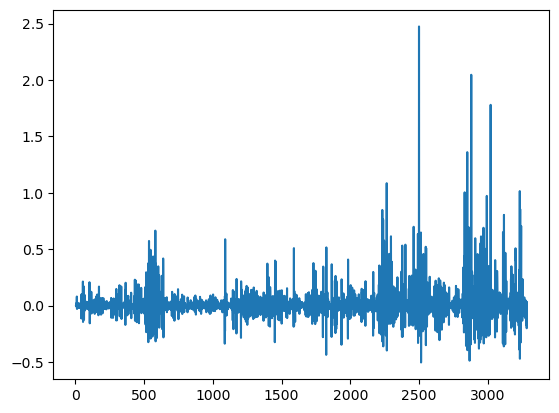

In [1099]:
plt.plot(std_res)

## DAR CLASS

In [1101]:
class DAR:
    def __init__(self, p):
        """
        Initialize the DAR class
        """
        self.p = p
        self.params = None
        self.num_params = 1 + 2 * self.p
        self.loglike_val = None

    def t(self, Y):
        T = len(Y)
        self.T = T
        t = np.arange(start=-1, stop=-(T+1), step=-1)
        
        return t
    
    def y(self, Y):
        
        max_lag = self.p 

        Y = np.vstack((np.full((max_lag, Y.shape[1]), np.nan), Y))
        y = lambda t: Y[t,:]
        
        return y

    def parse_params(self, params):
        rho = params[:self.p]
        omega = params[self.p]
        alpha = params[self.p + 1:self.p + 1 + self.p]
        
        params_dict = {
            "rho": rho,
            "omega": omega,
            "alpha": alpha,
            }
        return params_dict

    def cond_var(self, Y, params = None):
        
        omega = params["omega"]
        alpha = params["alpha"]

        y = self.y(Y)
        
        cond_var = lambda t: omega + sum(alpha[i-1] * y(t-i)**2 for i in range(1, self.p+1))
        
        return cond_var
    
    def cond_mean(self, Y, params = None):
        
        rho = params["rho"]
        
        y = self.y(Y)
        cond_mean = lambda t: sum(rho[i-1] * y(t-i) for i in range(1, self.p + 1))
        return cond_mean
    
    def fit(self, Y, dist = "normal"):

        t = self.t(Y)

        def MLE(params):
            
            y = self.y(Y)

            if dist == "student-t":
                nu = params[-1]
                params = self.parse_params(params[:-1])
            
            else:
                params = self.parse_params(params)
            
            cond_mean = self.cond_mean(Y, params)
            cond_var = self.cond_var(Y, params)

            if dist == "normal":
                l_t = -1/2 * (np.log(cond_var(t)) + (y(t) - cond_mean(t))**2 / cond_var(t))
            
            elif dist == "student-t":
                term1 = -0.5 * np.log(cond_var(t) * (nu - 2) * np.pi)
                term2 = gammaln((nu + 1) / 2) - gammaln(nu / 2)
                term3 = -((nu + 1) / 2) * np.log(1 + ((y(t) - cond_mean(t)) ** 2) / (cond_var(t) * (nu - 2)))
                l_t = term1 + term2 + term3

            else:
                raise ValueError("dist must be 'normal' or 'student-t'")
            
            L_t = np.nansum(l_t)
            return -L_t
        
        # Initialize parameters
        rho_init = [0.0] * self.p
        omega_init = [0.05]
        alpha_init = [0.5] * self.p
        init_params = rho_init + omega_init + alpha_init

        # Set parameter bounds
        rho_bound = [(None, None)] * self.p
        omega_bound = [(0.001, None)]
        alpha_bound = [(0.001, None)] * self.p
        bounds_params = rho_bound + omega_bound + alpha_bound

        # studen-t degrees of freedom
        nu_init = [5]
        nu_bound = [(2.0001, None)]
        
        if dist == "student-t":
            init_params += nu_init
            bounds_params += nu_bound
        
        # opminise the loglikelihood function
        result = scipy.optimize.minimize(MLE, init_params, method='SLSQP', bounds=bounds_params)
        
        # store parameters
        if dist == "student-t":
            self.params = {**self.parse_params(result.x[:-1]), "nu": result.x[-1]}
        else:
            self.params = self.parse_params(result.x)

        # store loglikelihood value
        self.loglike_val = -result.fun
        
        return self

    def std_res(self, Y):
        
        t = self.t(Y)
        y = self.y(Y)

        cond_mean = self.cond_mean(Y, self.params)
        cond_var = self.cond_var(Y, self.params)

        z = lambda t: (y(t) - cond_mean(t)) / np.sqrt(cond_var(t))
        return np.flip(z(t))

    def predict(self, Y):
        
        t = self.t(Y)
        
        cond_mean = self.cond_mean(Y, self.params)
        
        return np.flip(np.append(cond_mean(t+1), np.nan)).reshape(-1,1)
    
    def CI(self, Y, alpha_level = 0.05, dist = "normal"):

        t = self.t(Y)
        cond_mean = self.cond_mean(Y, self.params)
        cond_var = self.cond_var(Y, self.params)

        if dist == "normal":
            z_val = norm.ppf(1 - alpha_level / 2)

        elif dist == "student-t":
            nu = self.params["nu"]
            z_val = student_t.ppf(1 - alpha_level / 2, df = nu) * np.sqrt((nu - 2) / nu)
        
        else:
            raise ValueError("dist must be 'normal' or 'student-t'")
        

        CI = lambda t: np.column_stack((cond_mean(t) + z_val * np.sqrt(cond_var(t)), 
                                        cond_mean(t) - z_val * np.sqrt(cond_var(t))
                                        ))
        
        return np.vstack((np.full((1, 2), np.nan), np.flip(CI(t+1))))


In [1119]:
Y = y_train[20]
model = DAR(p=1) # init model med p lag-struktur


array([[          nan,           nan],
       [-102.04069652,  561.70640309],
       [-113.6304263 ,  542.54363765],
       ...,
       [-135.53223887,  507.88568526],
       [-290.63858775,  312.22139363],
       [-197.87934156,  419.57360504]])

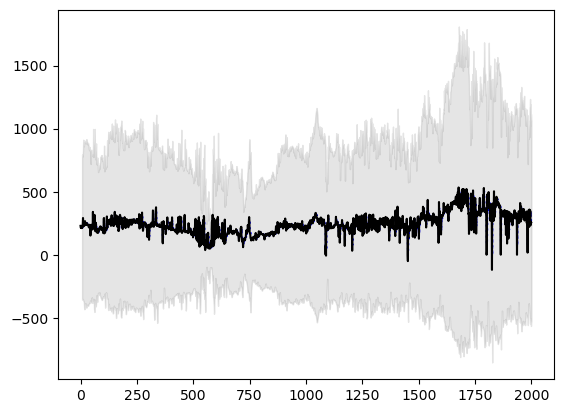

In [730]:
x_axis = range(len(fcast))

# Confidence interval as a shaded area
plt.fill_between(x_axis, CI[:, 0], CI[:, 1], color='grey', alpha=0.2)
plt.plot(x_axis, fcast, linestyle='dotted', color='blue')
plt.plot(x_axis, np.append(Y_test, np.nan), linestyle='solid', color='black')

# Show the plot
plt.show()